In [1]:
%matplotlib inline
import tensorflow as tf
import numpy
import matplotlib.pyplot as plt
from sklearn import datasets
from itertools import chain
rng = numpy.random

In [2]:
learning_rate = 0.0001
epochs = 10000

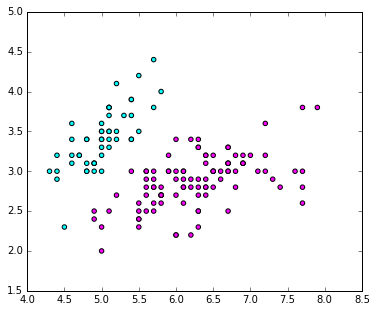

In [3]:
def loadDataset():
    dataset = datasets.load_iris()
    X = dataset['data']
    Z = dataset['target']
    X = X[:, :2]  # only look at 2 dimensions
    Z[Z == 2] = 1  # combine two of the 3 classes
    return numpy.array(X), numpy.array(Z)

xx, zz = loadDataset()
assert xx.shape[0] == zz.shape[0]
n_samples = len(xx)

# Display
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.scatter(xx[:, 0], xx[:, 1], c=zz,
           cmap=plt.cm.cool)
plt.show()

In [4]:
# Input
X = tf.placeholder(tf.float32, [None, 2], name="X")
Z = tf.placeholder(tf.float32, name="Z")
# Variables
W = tf.Variable(tf.random_normal([2, 1], stddev=.01),
                name="W")
b = tf.Variable(tf.random_normal([1], stddev=.01),
                name="b")
# Construct a linear model
Y = tf.nn.sigmoid(tf.matmul(X, W) + b)
# Minimize cross entropy
tf.scalar_product = lambda a, b: tf.matrix_determinant(
    tf.matmul(tf.expand_dims(a, 1), b, transpose_a=True))
cost = - (tf.scalar_product(Z, tf.log(Y)) +
          tf.scalar_product(1 - Z, tf.log(1 - Y)))
optimizer = tf.train \
    .GradientDescentOptimizer(learning_rate) \
    .minimize(cost)

In [5]:
# Set up session
sess = tf.Session()
# Logging
tf.scalar_summary('cost', cost)
merged_summaries = tf.merge_all_summaries()
summary_writer = tf.train.SummaryWriter("/tmp/linear_classification", sess.graph_def)
# Initialize the variables
sess.run(tf.initialize_all_variables())

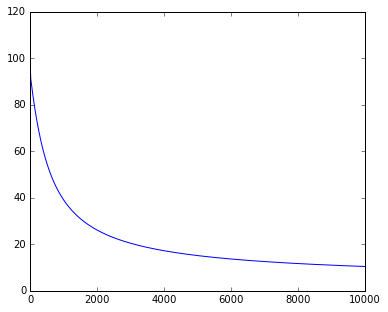

In [6]:
train_loss = []
for epoch in range(epochs):
    result = sess.run([optimizer, cost, merged_summaries],
                      feed_dict={X: xx, Z: zz})
    train_loss.append(result[1])
    summary_str = result[2]
    summary_writer.add_summary(summary_str, epoch)
f, ax = plt.subplots(figsize=(6, 5))
ax.plot(train_loss)
plt.show()

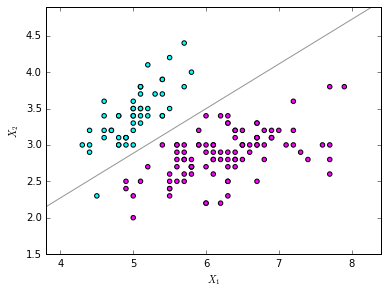

In [7]:
f, ax = plt.subplots(figsize=(6, 5))
# Training data
ax.scatter(xx[:, 0], xx[:, 1], c=zz,
           cmap=plt.cm.cool)
# Decision boundary
x0min, x0max = min(xx[:, 0]) - 0.5, max(xx[:, 0]) + 0.5
x1min, x1max = min(xx[:, 1]) - 0.5, max(xx[:, 1]) + 0.5
x0s, x1s = numpy.mgrid[x0min:x0max:.01, x1min:x1max:.01]
# the tensors are fixed and the input tensor can only 
# process values of size `n_samples`.
# fix by processing in batches
batch_size = len(xx)
surplus = len(x0s) % batch_size
x0s, x1s = x0s[:len(x0s) - surplus], x1s[:len(x1s) - surplus]
xs = numpy.c_[x0s.ravel(), x1s.ravel()]
rs = range(0, len(xs), batch_size)
xs_batches = [xs[r:r + batch_size]
              for r in rs]
ys_batches = [sess.run(Y, feed_dict={X: batch})
            for batch in xs_batches]
ys = numpy.concatenate(ys_batches)[:,0]

ax.contour(x0s, x1s, ys.reshape(x0s.shape), 
           levels=[.5], cmap="Greys",
           vmin=0, vmax=1
           )
# Plot
ax.set(aspect="equal",
       xlim=(x0min, x0max),
       ylim=(x1min, x1max),
       xlabel="$X_1$", ylabel="$X_2$")
plt.show()

In [8]:
sess.close()